In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install dask-ml --quiet
!pip install dask --quiet
!pip install kmodes --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#df_init = pd.read_csv('/content/drive/MyDrive/df_base.csv', low_memory = False)
#df_init['fecha_suceso'] = pd.to_datetime(df_init['fecha_suceso'])
iter_csv = pd.read_csv('/content/drive/MyDrive/Monografia_NYPD/df_base.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[ pd.to_datetime(chunk['fecha_suceso']).dt.year  >= 2016] for chunk in iter_csv])
pd.set_option('display.max_columns', None)
df.head()

,num_denuncia,fecha_suceso,hora_suceso,direccion_suceso,fecha_denuncia,delito_completado_interrumpido,nivel_ofensa,distrito,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,geoespacial,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,diff_dias_hecho_denuncia,dia_suceso,estacion_suceso,mes_suceso
0,506547392,2018-03-29,Noche,32.0,2018-03-30,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,UNKNOWN,UNKNOWN,Desconocido,"(40.810877241, -73.941064151)",25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,1,jueves,primavera,abril
1,629632833,2018-02-06,Noche,52.0,2018-02-07,COMPLETED,MISDEMEANOR,BRONX,Policia,45-64,BLACK,Femenino,"(40.873671035, -73.908013649)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,1,martes,invierno,marzo
2,787203902,2018-11-21,Madrugada,75.0,2018-11-21,COMPLETED,MISDEMEANOR,BROOKLYN,Policia,25-44,WHITE,Femenino,"(40.651782232, -73.885456761)",UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,0,miercoles,otono,diciembre
3,280364018,2018-06-09,Noche,10.0,2018-06-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,25-44,WHITE,Masculino,"(40.759310399, -73.994706072)",UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,1,sabado,verano,julio
4,985800320,2018-11-10,Noche,19.0,2018-11-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,<18,BLACK,Femenino,"(40.764535539, -73.970728388)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,0,sabado,otono,diciembre


Acotaremos el ejercicio a los distritos donde más casos hubieron

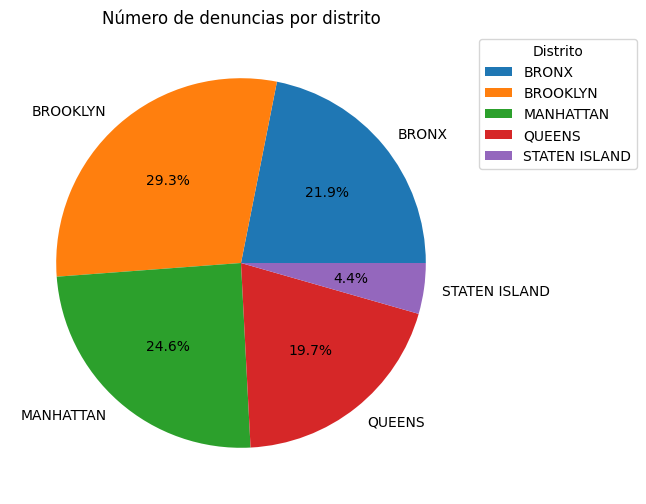

In [6]:
distritos_counts = df.groupby(['distrito']).size()

# Crear un gráfico de torta
plt.figure(figsize=(6, 6))
distritos_counts.plot.pie(autopct='%1.1f%%')
plt.title('Número de denuncias por distrito')
plt.legend(title='Distrito', labels=distritos_counts.index, bbox_to_anchor=(1, 1))
plt.show()

## MANHATTAN

In [7]:
df_manhattan = df[df.distrito == 'MANHATTAN'].copy()
df_manhattan.reset_index(inplace = True, drop = True)
df_manhattan['direccion_suceso'] = df_manhattan['direccion_suceso'].astype('object')

In [8]:
df_manhattan.drop(columns= ['fecha_suceso', 'fecha_denuncia', 'num_denuncia', 'direccion_suceso', 'distrito', 'diff_dias_hecho_denuncia', 'nivel_ofensa', 'delito_completado_interrumpido'], inplace = True)

Separamos coordenadas

In [9]:
df_manhattan['latitud'] = df_manhattan.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[0]))
df_manhattan['longitud'] = df_manhattan.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[1]))
df_manhattan.drop(columns= ['geoespacial'], inplace = True)
df_manhattan.head()

,hora_suceso,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,latitud,longitud
0,Noche,Policia,UNKNOWN,UNKNOWN,Desconocido,25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,jueves,primavera,abril,40.810877,-73.941064
1,Noche,Policia,25-44,WHITE,Masculino,UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,sabado,verano,julio,40.759310,-73.994706
2,Noche,Policia,<18,BLACK,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,sabado,otono,diciembre,40.764536,-73.970728
3,Mañana,Transito,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,extorsion,necesidades diarias,lunes,primavera,abril,40.804384,-73.937422
4,Noche,Policia,25-44,BLACK,Desconocido,25-44,BLACK,Masculino,delitos_graves,lugares publicos,miercoles,otono,octubre,40.803905,-73.952037


In [10]:
from sklearn.preprocessing import MinMaxScaler
num_cols = df_manhattan.select_dtypes('number')
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(num_cols), columns = num_cols.columns.tolist())
df_manhattan_ready = pd.concat([df_manhattan.drop(columns = num_cols.columns.tolist()), scaled], axis = 1)
df_manhattan_ready_sample = df_manhattan_ready.sample(frac = 0.05, replace = True, random_state=1234)

## **1ra iteración:** de 2016 a 2019
- Sin reducción de de dimensionalidad y aplicación de KMeans y, adicional, con reducción de dimensionalidad aplicando KMeans.

## **2da iteración:** De 2016 a 2019 y distrito con mayor número de casos
- Sin reducción de dimensionalidad y KModes.

### 1.1.1 Sin reducción de dimensionalidad y aplicación de KMeans.

Método del codo

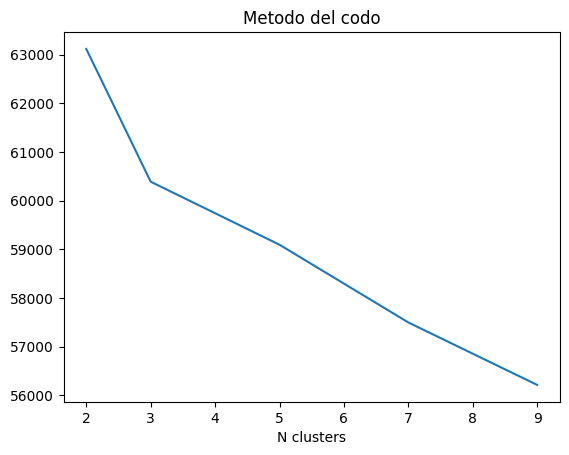

In [11]:
from sklearn.metrics import silhouette_score  
from dask_ml.cluster import KMeans as KMeansDask
import dask.dataframe as da

# crear matriz Dask
sample = df_manhattan_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()


### Cohesión y Separabilidad con diferentes numero de clusters
- **Calinski-Harabasz:** cuanto mayor sea el valor del índice  se considera que el clustering es mejor.

- **Silhoutte Score:** Un valor cercano a 1 indica que las muestras están bien asignadas a sus clusters y están alejadas de los otros clusters vecinos. Un valor cercano a 0 indica que las muestras están en o cerca del límite de decisión entre dos clusters vecinos. Un valor cercano a -1 indica que las muestras pueden haber sido asignadas incorrectamente a sus clusters y que están más cerca de los otros clusters vecinos.

In [ ]:
from sklearn import metrics
sample = df_manhattan_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
metrics_df_general = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(X, labels)
  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(X, labels)
  metrics_df = pd.DataFrame({'Metodo': ['KMeans'],
                           'k':[k],
                           'Calinski-Harabasz Index': [ch_score],
                           'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general = metrics_df_general.append(metrics_df, ignore_index=True)
metrics_df_general

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans,2,2746.653442,0.103252
1,KMeans,3,2418.787910,0.106804
2,KMeans,5,1716.989560,0.085804
3,KMeans,7,1316.076073,0.075724
4,KMeans,9,1007.873576,0.084520


### Centroides con KMeans y clusters igual a 3

In [12]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X)
centroids = kmeans.cluster_centers_ 
labels = kmeans.labels_ 

In [13]:
centroides_manhattan = pd.DataFrame(centroids, columns = pd.get_dummies(df_manhattan_ready_sample).columns.tolist())
centroides_manhattan.reset_index(inplace = True, drop = False)
centroides_manhattan.rename(columns = {'index':'cluster'}, inplace =True)
centroides_manhattan

,cluster,latitud,longitud,hora_suceso_Madrugada,hora_suceso_Mañana,hora_suceso_Noche,hora_suceso_Tarde,jurisdiccion_encargada_Externas,jurisdiccion_encargada_Otras,jurisdiccion_encargada_Policia,jurisdiccion_encargada_Transito,jurisdiccion_encargada_Vivienda,grupo_edad_sospechoso_25-44,grupo_edad_sospechoso_45-64,grupo_edad_sospechoso_<18,grupo_edad_sospechoso_UNKNOWN,raza_sospechoso_AMERICAN INDIAN/ALASKAN NATIVE,raza_sospechoso_ASIAN / PACIFIC ISLANDER,raza_sospechoso_BLACK,raza_sospechoso_UNKNOWN,raza_sospechoso_WHITE,sexo_sospechoso_Desconocido,sexo_sospechoso_Femenino,sexo_sospechoso_Masculino,grupo_edad_victima_25-44,grupo_edad_victima_45-64,grupo_edad_victima_<18,grupo_edad_victima_UNKNOWN,raza_victima_AMERICAN INDIAN/ALASKAN NATIVE,raza_victima_ASIAN / PACIFIC ISLANDER,raza_victima_BLACK,raza_victima_UNKNOWN,raza_victima_WHITE,sexo_victima_Femenino,sexo_victima_Masculino,sexo_victima_Transgenero,tipo_crimen_armas_drogas,tipo_crimen_crimenes_sexuales,tipo_crimen_delitos_graves,tipo_crimen_extorsion,tipo_crimen_incidentes_menores,tipo_crimen_otros_crimenes,lugar_Otros,lugar_diversion y turismo,lugar_lugares publicos,lugar_lugares solitarios,lugar_necesidades diarias,dia_suceso_domingo,dia_suceso_jueves,dia_suceso_lunes,dia_suceso_martes,dia_suceso_miercoles,dia_suceso_sabado,dia_suceso_viernes,estacion_suceso_invierno,estacion_suceso_otono,estacion_suceso_primavera,estacion_suceso_verano,mes_suceso_abril,mes_suceso_agosto,mes_suceso_diciembre,mes_suceso_febrero,mes_suceso_julio,mes_suceso_junio,mes_suceso_marzo,mes_suceso_mayo,mes_suceso_noviembre,mes_suceso_octubre,mes_suceso_septiembre
0,0,0.590578,0.244513,0.146333,0.166890,0.270527,0.416251,0.016421,0.015692,0.823866,0.070429,0.073592,0.279406,0.129668,0.021774,0.569152,0.001338,0.020800,0.375502,0.364797,0.237562,0.350079,0.115314,0.534606,0.000000,0.000243,0.000000,0.999757,0.000000,0.000730,0.000851,0.997202,0.001216,0.006690,0.010339,0.982970,0.152293,0.017394,0.016300,0.585574,0.207274,0.021165,0.032478,0.510157,0.328184,0.030288,0.098893,0.111422,0.159226,0.128208,0.143292,0.158861,0.137818,0.161173,0.233427,0.252281,0.249970,0.264323,0.081012,0.085878,0.154118,0.089162,0.088919,0.090135,0.068605,0.078823,0.093906,0.079917,0.089527
1,1,0.602880,0.249786,0.144951,0.213249,0.283600,0.358200,0.002931,0.008208,0.905760,0.032537,0.050564,0.003078,0.001905,0.000879,0.994137,0.000293,0.001905,0.010113,0.977722,0.009966,0.948263,0.020959,0.030778,0.460501,0.250916,0.027554,0.261029,0.007914,0.106551,0.244174,0.080903,0.560457,0.475158,0.523963,0.000879,0.001026,0.087938,0.067566,0.705994,0.132933,0.004543,0.034735,0.205775,0.658655,0.018027,0.082808,0.125458,0.141580,0.144365,0.136450,0.137183,0.151253,0.163711,0.227466,0.249744,0.249744,0.273047,0.079291,0.087938,0.169134,0.073135,0.091162,0.091748,0.068445,0.078704,0.088671,0.077825,0.093947
2,2,0.629185,0.267608,0.179302,0.196550,0.294504,0.329643,0.004505,0.008367,0.791222,0.046595,0.149311,0.418587,0.143004,0.046982,0.391427,0.003990,0.034754,0.545373,0.068349,0.347535,0.016991,0.229116,0.753894,0.479598,0.232591,0.063715,0.224096,0.007852,0.087527,0.388081,0.055863,0.460677,0.564809,0.434805,0.000386,0.004891,0.325911,0.308276,0.177758,0.156648,0.026516,0.033338,0.131420,0.720813,0.022654,0.091775,0.149826,0.144678,0.132578,0.139658,0.144034,0.145450,0.143777,0.227829,0.257562,0.249324,0.265285,0.079676,0.092419,0.160381,0.076844,0.089072,0.087399,0.070408,0.082250,0.090874,0.086884,0.083795


In [14]:
manhattan_kmeans_sin_reduccion = df_manhattan_ready_sample.copy()
manhattan_kmeans_sin_reduccion['clusters'] = kmeans.labels_

### Análisis de clusters en KMeans sin reducción

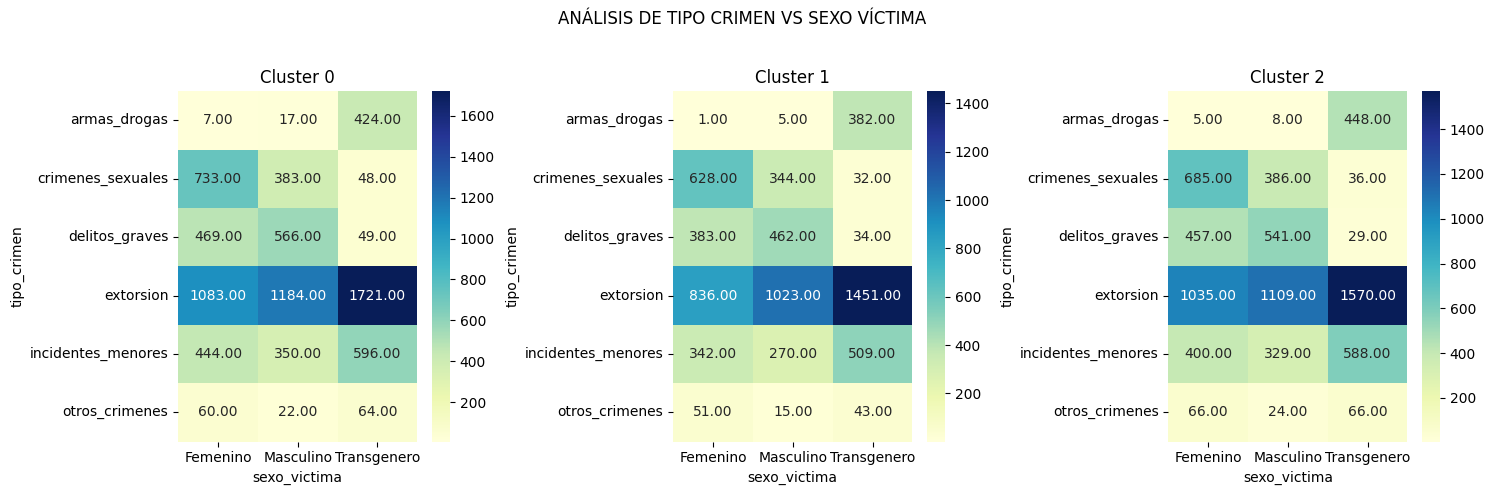

In [15]:
manhattan_cluster0 = manhattan_kmeans_sin_reduccion[manhattan_kmeans_sin_reduccion['clusters']==0]
manhattan_cluster1 = manhattan_kmeans_sin_reduccion[manhattan_kmeans_sin_reduccion['clusters']==1]
manhattan_cluster2 = manhattan_kmeans_sin_reduccion[manhattan_kmeans_sin_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster0['tipo_crimen'], manhattan_cluster0['sexo_victima'])
ct1 = pd.crosstab(manhattan_cluster1['tipo_crimen'], manhattan_cluster1['sexo_victima'])
ct2 = pd.crosstab(manhattan_cluster2['tipo_crimen'], manhattan_cluster2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

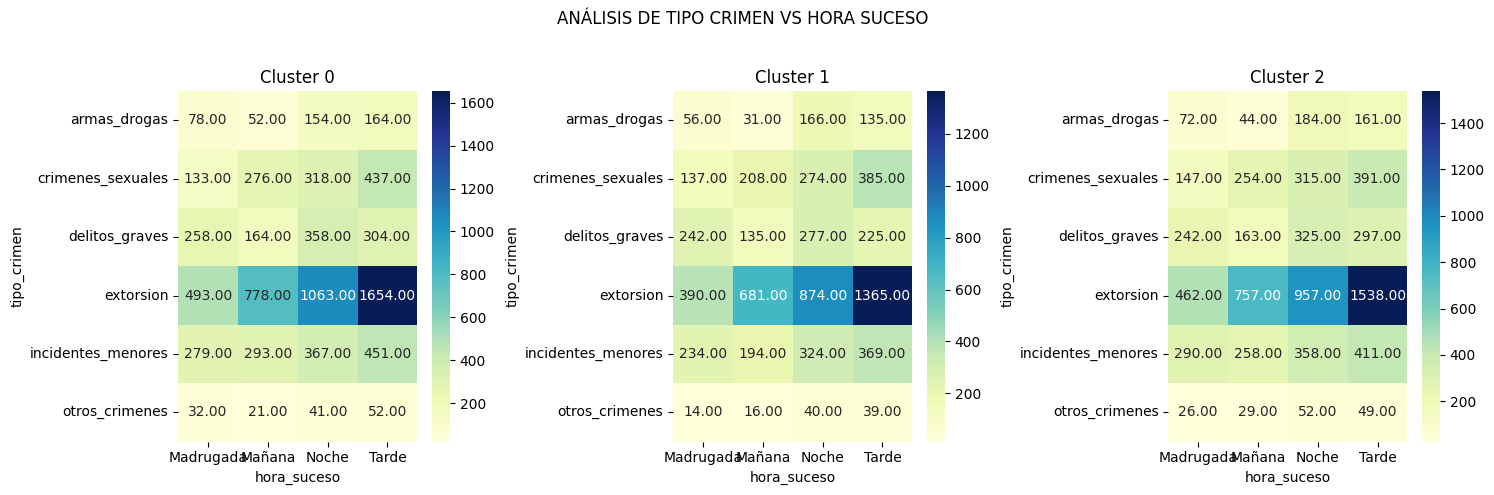

In [16]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(manhattan_cluster0['tipo_crimen'], manhattan_cluster0['hora_suceso'])
ct1 = pd.crosstab(manhattan_cluster1['tipo_crimen'], manhattan_cluster1['hora_suceso'])
ct2 = pd.crosstab(manhattan_cluster2['tipo_crimen'], manhattan_cluster2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

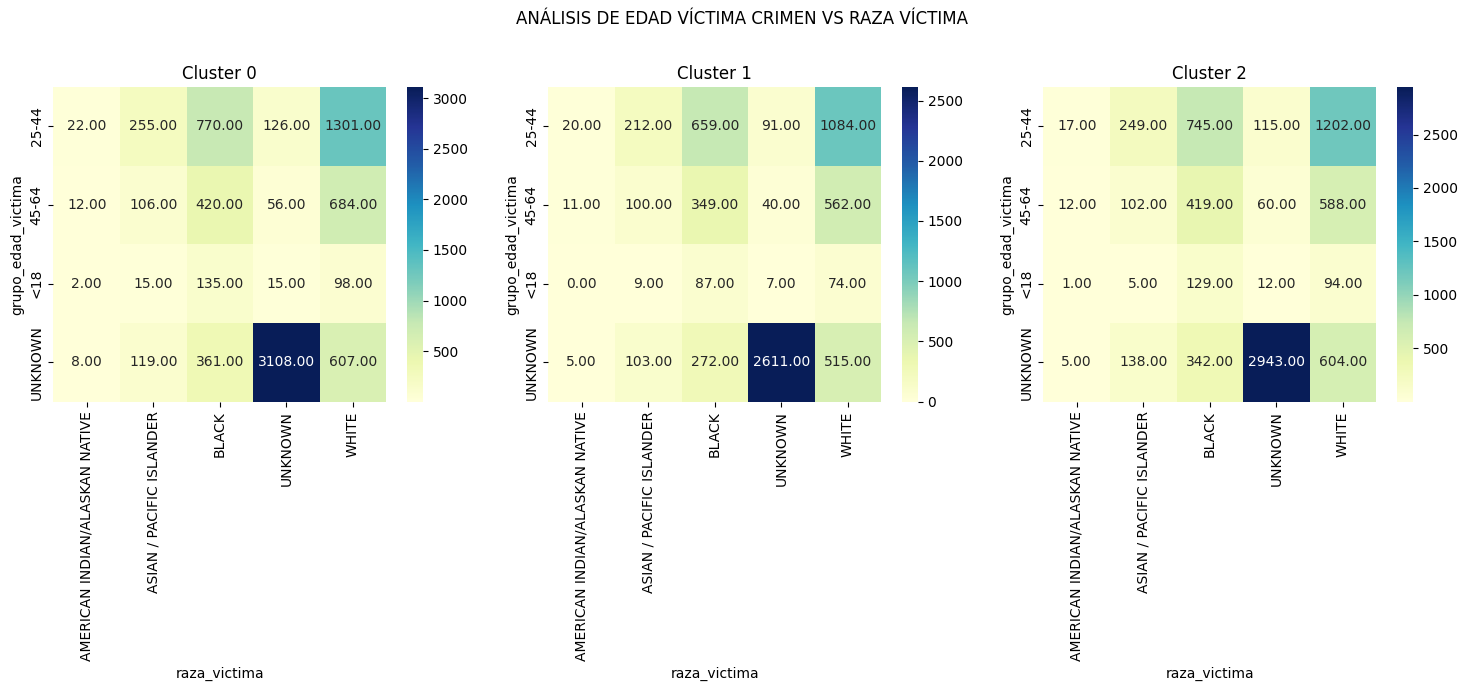

In [17]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster0['grupo_edad_victima'], manhattan_cluster0['raza_victima'])
ct1 = pd.crosstab(manhattan_cluster1['grupo_edad_victima'], manhattan_cluster1['raza_victima'])
ct2 = pd.crosstab(manhattan_cluster2['grupo_edad_victima'], manhattan_cluster2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [19]:
for column in manhattan_kmeans_sin_reduccion.columns:
  if column not in ['clusters', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    aux1 = manhattan_kmeans_sin_reduccion.groupby(['clusters', column]).size().reset_index().rename(columns = {0:'casos'})
    aux2 = manhattan_kmeans_sin_reduccion.groupby('clusters').size().reset_index().rename(columns = {0:'casos_totales'})
    aux3 = aux1.merge(aux2,how='left', on = 'clusters')
    aux3['participacion'] = aux3['casos']/aux3['casos_totales']
    aux3.drop(columns = ['casos_totales'], inplace = True)
    pd.options.display.float_format = '{:.1%}'.format 
    display(aux3)
    print('\n')
  pd.reset_option('display.float_format')

Variable hora_suceso:


,clusters,hora_suceso,casos,participacion
0,0,Madrugada,1273,15.5%
1,0,Mañana,1584,19.3%
2,0,Noche,2301,28.0%
3,0,Tarde,3062,37.3%
4,1,Madrugada,1073,15.8%
5,1,Mañana,1265,18.6%
6,1,Noche,1955,28.7%
7,1,Tarde,2518,37.0%
8,2,Madrugada,1239,15.9%
9,2,Mañana,1505,19.3%




Variable jurisdiccion_encargada:


,clusters,jurisdiccion_encargada,casos,participacion
0,0,Externas,63,0.8%
1,0,Otras,90,1.1%
2,0,Policia,6865,83.5%
3,0,Transito,436,5.3%
4,0,Vivienda,766,9.3%
5,1,Externas,64,0.9%
6,1,Otras,71,1.0%
7,1,Policia,5734,84.2%
8,1,Transito,338,5.0%
9,1,Vivienda,604,8.9%




Variable grupo_edad_sospechoso:


,clusters,grupo_edad_sospechoso,casos,participacion
0,0,25-44,2004,24.4%
1,0,45-64,777,9.5%
2,0,<18,194,2.4%
3,0,UNKNOWN,5245,63.8%
4,1,25-44,1690,24.8%
5,1,45-64,666,9.8%
6,1,<18,157,2.3%
7,1,UNKNOWN,4298,63.1%
8,2,25-44,1876,24.1%
9,2,45-64,747,9.6%




Variable raza_sospechoso:


,clusters,raza_sospechoso,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,15,0.2%
1,0,ASIAN / PACIFIC ISLANDER,151,1.8%
2,0,BLACK,2643,32.2%
3,0,UNKNOWN,3696,45.0%
4,0,WHITE,1715,20.9%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,14,0.2%
6,1,ASIAN / PACIFIC ISLANDER,145,2.1%
7,1,BLACK,2214,32.5%
8,1,UNKNOWN,3061,44.9%
9,1,WHITE,1377,20.2%




Variable sexo_sospechoso:


,clusters,sexo_sospechoso,casos,participacion
0,0,Desconocido,3408,41.5%
1,0,Femenino,1042,12.7%
2,0,Masculino,3770,45.9%
3,1,Desconocido,2839,41.7%
4,1,Femenino,860,12.6%
5,1,Masculino,3112,45.7%
6,2,Desconocido,3233,41.5%
7,2,Femenino,969,12.5%
8,2,Masculino,3580,46.0%




Variable grupo_edad_victima:


,clusters,grupo_edad_victima,casos,participacion
0,0,25-44,2474,30.1%
1,0,45-64,1278,15.5%
2,0,<18,265,3.2%
3,0,UNKNOWN,4203,51.1%
4,1,25-44,2066,30.3%
5,1,45-64,1062,15.6%
6,1,<18,177,2.6%
7,1,UNKNOWN,3506,51.5%
8,2,25-44,2328,29.9%
9,2,45-64,1181,15.2%




Variable raza_victima:


,clusters,raza_victima,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,44,0.5%
1,0,ASIAN / PACIFIC ISLANDER,495,6.0%
2,0,BLACK,1686,20.5%
3,0,UNKNOWN,3305,40.2%
4,0,WHITE,2690,32.7%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,36,0.5%
6,1,ASIAN / PACIFIC ISLANDER,424,6.2%
7,1,BLACK,1367,20.1%
8,1,UNKNOWN,2749,40.4%
9,1,WHITE,2235,32.8%




Variable sexo_victima:


,clusters,sexo_victima,casos,participacion
0,0,Femenino,2796,34.0%
1,0,Masculino,2522,30.7%
2,0,Transgenero,2902,35.3%
3,1,Femenino,2241,32.9%
4,1,Masculino,2119,31.1%
5,1,Transgenero,2451,36.0%
6,2,Femenino,2648,34.0%
7,2,Masculino,2397,30.8%
8,2,Transgenero,2737,35.2%




Variable tipo_crimen:


,clusters,tipo_crimen,casos,participacion
0,0,armas_drogas,448,5.5%
1,0,crimenes_sexuales,1164,14.2%
2,0,delitos_graves,1084,13.2%
3,0,extorsion,3988,48.5%
4,0,incidentes_menores,1390,16.9%
5,0,otros_crimenes,146,1.8%
6,1,armas_drogas,388,5.7%
7,1,crimenes_sexuales,1004,14.7%
8,1,delitos_graves,879,12.9%
9,1,extorsion,3310,48.6%




Variable lugar:


,clusters,lugar,casos,participacion
0,0,Otros,279,3.4%
1,0,diversion y turismo,2367,28.8%
2,0,lugares publicos,4596,55.9%
3,0,lugares solitarios,191,2.3%
4,0,necesidades diarias,787,9.6%
5,1,Otros,243,3.6%
6,1,diversion y turismo,2009,29.5%
7,1,lugares publicos,3802,55.8%
8,1,lugares solitarios,159,2.3%
9,1,necesidades diarias,598,8.8%




Variable dia_suceso:


,clusters,dia_suceso,casos,participacion
0,0,domingo,1070,13.0%
1,0,jueves,1222,14.9%
2,0,lunes,1128,13.7%
3,0,martes,1113,13.5%
4,0,miercoles,1224,14.9%
5,0,sabado,1180,14.4%
6,0,viernes,1283,15.6%
7,1,domingo,880,12.9%
8,1,jueves,1011,14.8%
9,1,lunes,892,13.1%




Variable estacion_suceso:


,clusters,estacion_suceso,casos,participacion
0,0,invierno,1924,23.4%
1,0,otono,2092,25.5%
2,0,primavera,2040,24.8%
3,0,verano,2164,26.3%
4,1,invierno,1520,22.3%
5,1,otono,1774,26.0%
6,1,primavera,1697,24.9%
7,1,verano,1820,26.7%
8,2,invierno,1797,23.1%
9,2,otono,1913,24.6%




Variable mes_suceso:


,clusters,mes_suceso,casos,participacion
0,0,abril,649,7.9%
1,0,agosto,729,8.9%
2,0,diciembre,1350,16.4%
3,0,febrero,661,8.0%
4,0,julio,738,9.0%
5,0,junio,723,8.8%
6,0,marzo,581,7.1%
7,0,mayo,668,8.1%
8,0,noviembre,729,8.9%
9,0,octubre,695,8.5%


### 1.2 Con reducción de dimensionalidad y aplicación de KMeans.

In [20]:
from dask_ml.decomposition import PCA

dummies = pd.get_dummies(df_manhattan_ready_sample, dtype ='int')
# crear matriz Dask
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 

# crear objeto PCA
pca = PCA(n_components=X.shape[1])

# ajustar el modelo
pca.fit(X)

PCA(n_components=68)

In [21]:
pca.explained_variance_ratio_[:40].sum(axis = 0)

0.9735270579758901

In [22]:
pca = PCA(n_components=40)
X_PCA =pca.fit_transform(X)
#X_PCA = X_PCA.compute() 

In [23]:
X_PCA_ok = pd.DataFrame(X_PCA, columns = ['component'+str(column) for column in range(X_PCA.shape[1])])
X_PCA_ok.head()

,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,1.088747,-0.788735,-1.138241,-0.449637,0.125609,0.289068,-1.073419,0.229798,0.428834,-0.353834,-0.055013,0.299204,-0.212838,-0.473970,-0.196563,-0.559622,-0.078963,-0.971958,0.187779,0.002709,0.133566,-0.167259,0.544667,0.040691,-0.273420,-0.611116,-0.151849,-0.214975,-0.089842,-0.001361,0.028984,-0.013625,-0.104090,0.031049,-0.128680,-0.152536,-0.150701,0.045687,-0.061306,0.029536
1,-1.386150,0.544324,0.526934,-0.544686,-0.430375,0.250766,-0.001922,1.535780,0.142297,-0.086684,0.507673,0.417419,0.142376,-0.108403,0.192420,0.210330,-0.475859,0.255836,-0.136593,-0.736444,0.393097,-0.113726,0.537008,0.190977,-0.166914,0.318516,0.191179,0.018847,-0.521250,0.009663,-0.083070,-0.026425,-0.189764,-0.016928,-0.196218,-0.166489,-0.060584,-0.223835,0.063311,-0.059569
2,-1.058931,0.192060,0.432448,-0.777490,-0.555825,0.435198,0.464176,0.678205,-0.565768,0.084141,0.594350,0.165210,0.414377,0.531449,-0.158751,-0.246514,0.848948,0.290583,0.939089,0.069773,0.225526,-0.132626,0.896673,-0.591969,0.027443,-0.036391,0.538492,0.263085,0.728825,0.007325,0.104736,0.042136,0.192260,0.114704,0.075966,0.232248,0.218950,-0.247835,0.062189,-0.191534
3,-1.822649,0.090788,-0.736790,-0.323636,-0.572777,0.179607,-0.032324,-0.720672,-0.177837,-0.199546,-0.839988,0.276498,0.159568,0.181327,0.028032,0.473316,0.272129,0.181117,-0.067134,-0.346664,-0.614199,-0.285887,0.830684,-0.251630,-0.505380,-0.185856,0.203410,-0.382908,0.527400,-0.032496,0.018317,0.046333,0.054378,0.030935,0.058090,0.104584,0.035926,-0.077213,-0.027115,-0.038604
4,0.464824,0.406636,1.103529,-0.538854,1.016831,-0.070320,-0.063133,-0.507153,-0.030044,-0.294703,-0.815488,-0.249778,0.118785,0.197860,1.132427,0.052358,0.336411,-0.778039,0.087068,-0.082040,0.005229,-0.218345,-0.077369,0.645227,0.038350,0.260242,-0.773218,-0.692824,0.109103,-0.015560,0.061992,-0.399360,0.449445,-0.233365,-0.521864,-0.071605,0.633644,0.243203,-0.104073,-0.209589


Según el método del codo, cuántos cluster serían una elección óptima?

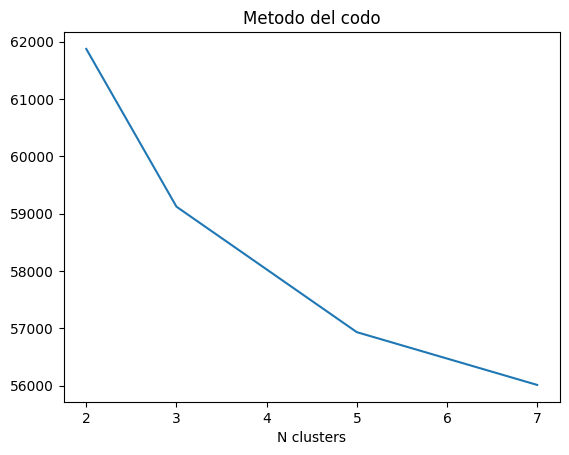

In [24]:
n_clusters = [2, 3, 5, 7]

km = []

for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k, random_state = 1234)
  kmeans.fit(X_PCA_ok)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()

### Calinski-Harabasz Index y Silhouette Coefficient para n clusters en KMeans con PCA

In [ ]:
metrics_df_general_pca = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
n_clusters = [2,3,5,7,9]
km = []
sample = X_PCA_ok.sample(frac=0.3)
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(sample) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KMeans_PCA'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_pca = metrics_df_general_pca.append(metrics_df, ignore_index=True)

metrics_df_general_pca

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans_PCA,2,801.849735,0.100205
1,KMeans_PCA,3,756.083284,0.110207
2,KMeans_PCA,5,531.685108,0.088195
3,KMeans_PCA,7,417.828148,0.083962
4,KMeans_PCA,9,330.911165,0.058828


### Centroides con KMeans y PCA y clusters igual a 3

In [25]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X_PCA_ok)
centroids = kmeans.cluster_centers_ 
labels_pca = kmeans.labels_ 

In [26]:
centroides_mahattan_pca = pd.DataFrame(centroids, columns = X_PCA_ok.columns.tolist())
centroides_mahattan_pca.reset_index(inplace = True, drop = False)
centroides_mahattan_pca.rename(columns = {'index':'cluster'}, inplace =True)
centroides_mahattan_pca

,cluster,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,0,1.073390,-0.631876,-0.071088,-0.001015,0.000123,0.005094,0.000337,-0.009517,0.007921,0.053098,-0.025216,0.030688,-0.043000,0.028996,0.019178,-0.009845,-0.088510,0.002164,-0.000091,-0.001845,-0.003609,-0.002642,0.002194,0.004225,0.007626,0.019187,0.002627,-0.040344,0.014320,-0.001311,0.004779,0.004110,-0.004873,-0.019987,0.006312,-0.003041,-0.010555,0.019959,-0.012866,0.004297
1,1,0.287535,1.082677,-0.092123,0.006086,0.022022,0.011934,0.007436,-0.019794,0.018776,-0.035842,0.000966,-0.064189,0.084261,-0.015537,-0.008174,-0.021388,0.049855,-0.004243,0.003622,0.017651,-0.001833,-0.005382,0.007867,0.000524,0.034659,0.027906,-0.010574,-0.020103,-0.014505,-0.004290,-0.003230,-0.007802,-0.002150,-0.023867,0.004963,0.002514,0.008048,-0.020307,0.012747,-0.000993
2,2,-1.168807,-0.469040,0.144950,-0.004772,-0.020457,-0.015315,-0.007156,0.026301,-0.024017,-0.011545,0.020321,0.033507,-0.041700,-0.010035,-0.008581,0.028050,0.028387,0.002101,-0.003271,-0.014761,0.004731,0.007197,-0.009117,-0.004039,-0.038449,-0.041934,0.007563,0.052521,0.001359,0.005068,-0.001035,0.003753,0.006087,0.038874,-0.009897,0.000235,0.001442,0.001976,-0.000957,-0.002698


In [27]:
manhattan_kmeans_con_reduccion = df_manhattan_ready_sample.copy()
manhattan_kmeans_con_reduccion['clusters'] = labels_pca

### Análisis de clusters en KMeans con reducción

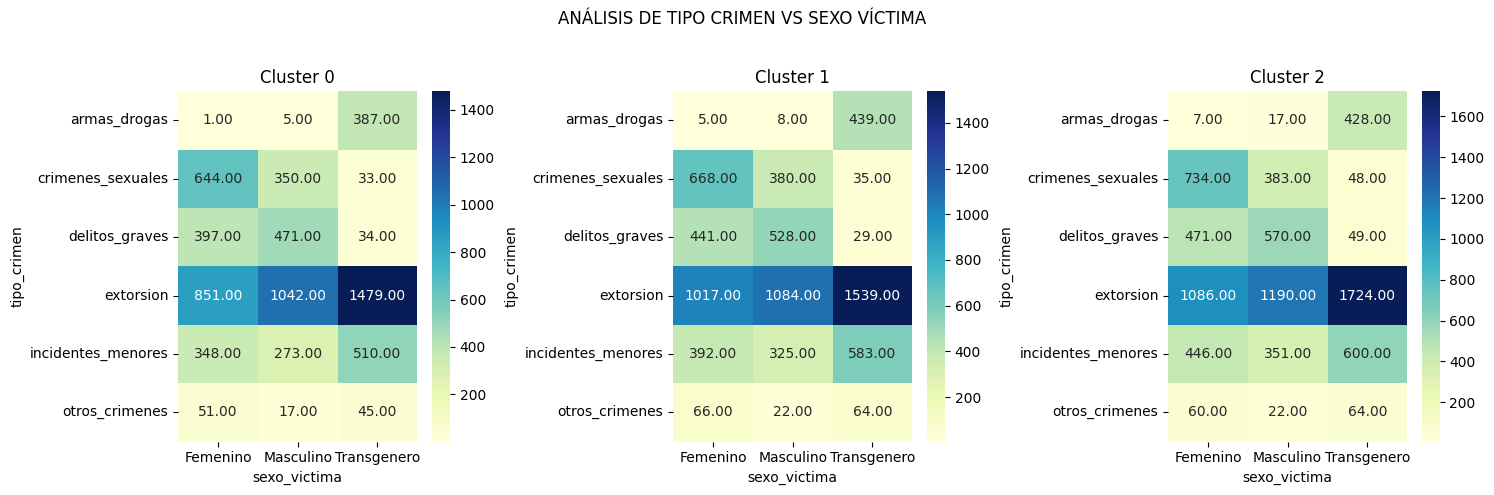

In [28]:
manhattan_cluster_pca0 = manhattan_kmeans_con_reduccion[manhattan_kmeans_con_reduccion['clusters']==0]
manhattan_cluster_pca1 = manhattan_kmeans_con_reduccion[manhattan_kmeans_con_reduccion['clusters']==1]
manhattan_cluster_pca2 = manhattan_kmeans_con_reduccion[manhattan_kmeans_con_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster_pca0['tipo_crimen'], manhattan_cluster_pca0['sexo_victima'])
ct1 = pd.crosstab(manhattan_cluster_pca1['tipo_crimen'], manhattan_cluster_pca1['sexo_victima'])
ct2 = pd.crosstab(manhattan_cluster_pca2['tipo_crimen'], manhattan_cluster_pca2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

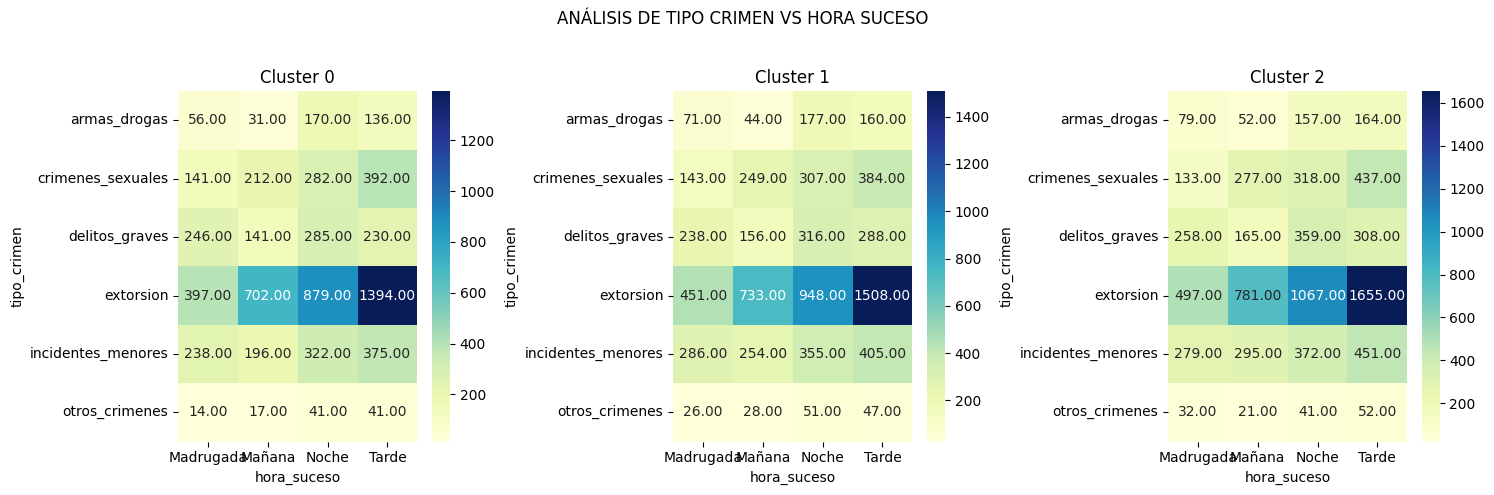

In [29]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(manhattan_cluster_pca0['tipo_crimen'], manhattan_cluster_pca0['hora_suceso'])
ct1 = pd.crosstab(manhattan_cluster_pca1['tipo_crimen'], manhattan_cluster_pca1['hora_suceso'])
ct2 = pd.crosstab(manhattan_cluster_pca2['tipo_crimen'], manhattan_cluster_pca2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

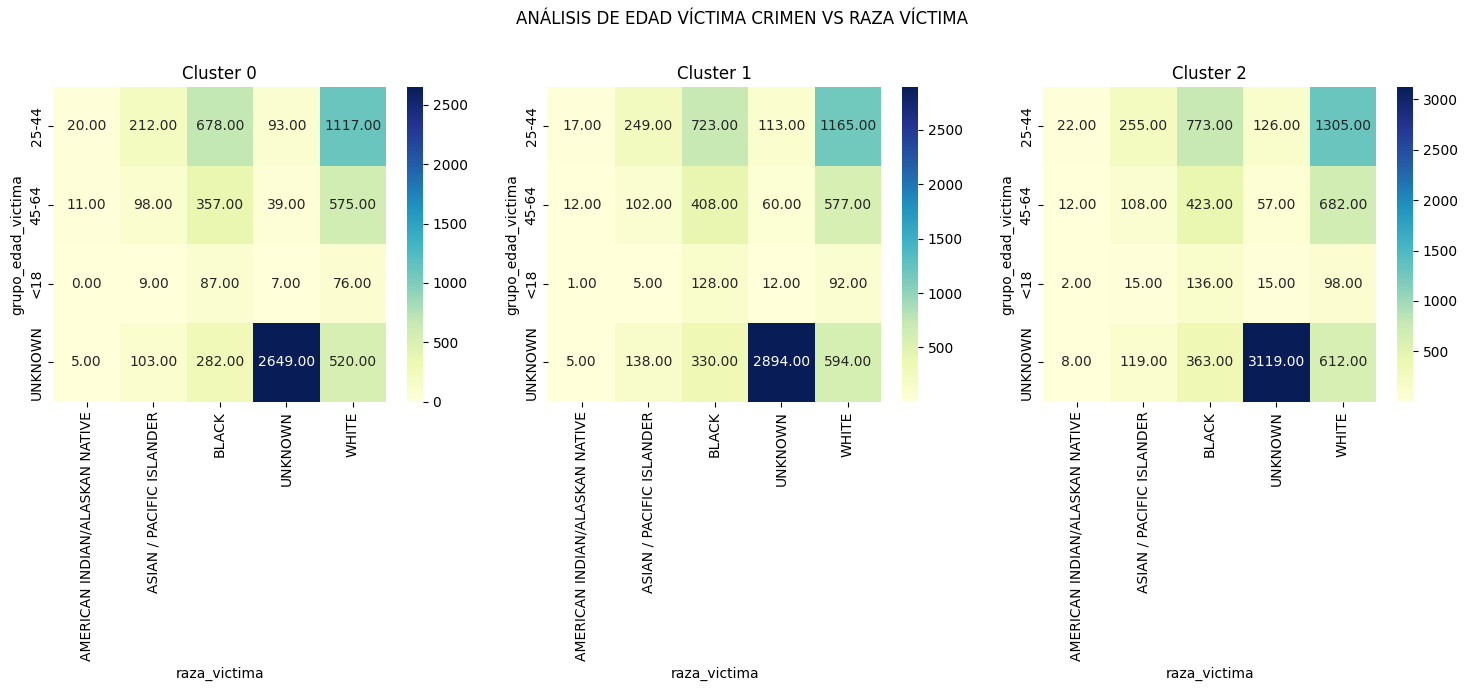

In [30]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster_pca0['grupo_edad_victima'], manhattan_cluster_pca0['raza_victima'])
ct1 = pd.crosstab(manhattan_cluster_pca1['grupo_edad_victima'], manhattan_cluster_pca1['raza_victima'])
ct2 = pd.crosstab(manhattan_cluster_pca2['grupo_edad_victima'], manhattan_cluster_pca2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [31]:
for column in manhattan_kmeans_con_reduccion.columns:
  if column not in ['clusters', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    aux1 = manhattan_kmeans_con_reduccion.groupby(['clusters', column]).size().reset_index().rename(columns = {0:'casos'})
    aux2 = manhattan_kmeans_con_reduccion.groupby('clusters').size().reset_index().rename(columns = {0:'casos_totales'})
    aux3 = aux1.merge(aux2,how='left', on = 'clusters')
    aux3['participacion'] = aux3['casos']/aux3['casos_totales']
    aux3.drop(columns = ['casos_totales'], inplace = True)
    pd.options.display.float_format = '{:.1%}'.format 
    display(aux3)
    print('\n')
  pd.reset_option('display.float_format')

Variable hora_suceso:


,clusters,hora_suceso,casos,participacion
0,0,Madrugada,1092,15.7%
1,0,Mañana,1299,18.7%
2,0,Noche,1979,28.5%
3,0,Tarde,2568,37.0%
4,1,Madrugada,1215,15.9%
5,1,Mañana,1464,19.2%
6,1,Noche,2154,28.2%
7,1,Tarde,2792,36.6%
8,2,Madrugada,1278,15.5%
9,2,Mañana,1591,19.3%




Variable jurisdiccion_encargada:


,clusters,jurisdiccion_encargada,casos,participacion
0,0,Externas,66,1.0%
1,0,Otras,74,1.1%
2,0,Policia,5836,84.1%
3,0,Transito,340,4.9%
4,0,Vivienda,622,9.0%
5,1,Externas,61,0.8%
6,1,Otras,85,1.1%
7,1,Policia,6381,83.7%
8,1,Transito,382,5.0%
9,1,Vivienda,716,9.4%




Variable grupo_edad_sospechoso:


,clusters,grupo_edad_sospechoso,casos,participacion
0,0,25-44,1727,24.9%
1,0,45-64,673,9.7%
2,0,<18,158,2.3%
3,0,UNKNOWN,4380,63.1%
4,1,25-44,1831,24.0%
5,1,45-64,737,9.7%
6,1,<18,198,2.6%
7,1,UNKNOWN,4859,63.7%
8,2,25-44,2012,24.4%
9,2,45-64,780,9.5%




Variable raza_sospechoso:


,clusters,raza_sospechoso,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,14,0.2%
1,0,ASIAN / PACIFIC ISLANDER,144,2.1%
2,0,BLACK,2255,32.5%
3,0,UNKNOWN,3121,45.0%
4,0,WHITE,1404,20.2%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,15,0.2%
6,1,ASIAN / PACIFIC ISLANDER,158,2.1%
7,1,BLACK,2478,32.5%
8,1,UNKNOWN,3372,44.2%
9,1,WHITE,1602,21.0%




Variable sexo_sospechoso:


,clusters,sexo_sospechoso,casos,participacion
0,0,Desconocido,2887,41.6%
1,0,Femenino,883,12.7%
2,0,Masculino,3168,45.7%
3,1,Desconocido,3174,41.6%
4,1,Femenino,943,12.4%
5,1,Masculino,3508,46.0%
6,2,Desconocido,3419,41.4%
7,2,Femenino,1045,12.7%
8,2,Masculino,3786,45.9%




Variable grupo_edad_victima:


,clusters,grupo_edad_victima,casos,participacion
0,0,25-44,2120,30.6%
1,0,45-64,1080,15.6%
2,0,<18,179,2.6%
3,0,UNKNOWN,3559,51.3%
4,1,25-44,2267,29.7%
5,1,45-64,1159,15.2%
6,1,<18,238,3.1%
7,1,UNKNOWN,3961,51.9%
8,2,25-44,2481,30.1%
9,2,45-64,1282,15.5%




Variable raza_victima:


,clusters,raza_victima,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,36,0.5%
1,0,ASIAN / PACIFIC ISLANDER,422,6.1%
2,0,BLACK,1404,20.2%
3,0,UNKNOWN,2788,40.2%
4,0,WHITE,2288,33.0%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,35,0.5%
6,1,ASIAN / PACIFIC ISLANDER,494,6.5%
7,1,BLACK,1589,20.8%
8,1,UNKNOWN,3079,40.4%
9,1,WHITE,2428,31.8%




Variable sexo_victima:


,clusters,sexo_victima,casos,participacion
0,0,Femenino,2292,33.0%
1,0,Masculino,2158,31.1%
2,0,Transgenero,2488,35.9%
3,1,Femenino,2589,34.0%
4,1,Masculino,2347,30.8%
5,1,Transgenero,2689,35.3%
6,2,Femenino,2804,34.0%
7,2,Masculino,2533,30.7%
8,2,Transgenero,2913,35.3%




Variable tipo_crimen:


,clusters,tipo_crimen,casos,participacion
0,0,armas_drogas,393,5.7%
1,0,crimenes_sexuales,1027,14.8%
2,0,delitos_graves,902,13.0%
3,0,extorsion,3372,48.6%
4,0,incidentes_menores,1131,16.3%
5,0,otros_crimenes,113,1.6%
6,1,armas_drogas,452,5.9%
7,1,crimenes_sexuales,1083,14.2%
8,1,delitos_graves,998,13.1%
9,1,extorsion,3640,47.7%




Variable lugar:


,clusters,lugar,casos,participacion
0,0,Otros,243,3.5%
1,0,diversion y turismo,2043,29.4%
2,0,lugares publicos,3883,56.0%
3,0,lugares solitarios,161,2.3%
4,0,necesidades diarias,608,8.8%
5,1,Otros,241,3.2%
6,1,diversion y turismo,2205,28.9%
7,1,lugares publicos,4293,56.3%
8,1,lugares solitarios,195,2.6%
9,1,necesidades diarias,691,9.1%




Variable dia_suceso:


,clusters,dia_suceso,casos,participacion
0,0,domingo,900,13.0%
1,0,jueves,1026,14.8%
2,0,lunes,905,13.0%
3,0,martes,1019,14.7%
4,0,miercoles,1000,14.4%
5,0,sabado,998,14.4%
6,0,viernes,1090,15.7%
7,1,domingo,961,12.6%
8,1,jueves,1147,15.0%
9,1,lunes,1026,13.5%




Variable estacion_suceso:


,clusters,estacion_suceso,casos,participacion
0,0,invierno,1550,22.3%
1,0,otono,1819,26.2%
2,0,primavera,1736,25.0%
3,0,verano,1833,26.4%
4,1,invierno,1762,23.1%
5,1,otono,1863,24.4%
6,1,primavera,1913,25.1%
7,1,verano,2087,27.4%
8,2,invierno,1929,23.4%
9,2,otono,2097,25.4%




Variable mes_suceso:


,clusters,mes_suceso,casos,participacion
0,0,abril,553,8.0%
1,0,agosto,584,8.4%
2,0,diciembre,1115,16.1%
3,0,febrero,549,7.9%
4,0,julio,595,8.6%
5,0,junio,639,9.2%
6,0,marzo,466,6.7%
7,0,mayo,544,7.8%
8,0,noviembre,670,9.7%
9,0,octubre,569,8.2%


### **2 Sin reducción de dimensionalidad y aplicación de KModes.**

Se excluyen algunas variables para el análisis

In [32]:
df_manhattan_ready.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)
df_manhattan_ready_sample.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


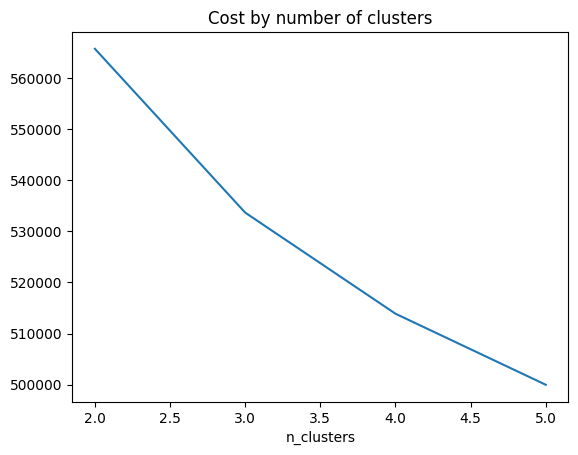

In [33]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_manhattan = df_manhattan_ready.copy()
categoricas_manhattan_encoded = encoder.fit_transform(df_manhattan_ready)

cost = []
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(categoricas_manhattan_encoded.sample(frac =0.2))
  cost.append(kmodes.cost_)

plt.title('Cost by number of clusters')
plt.xlabel('n_clusters')
plt.plot(n_clusters, cost)
plt.show()

In [ ]:
encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_manhattan = df_manhattan_ready.copy()
categoricas_manhattan_encoded = encoder.fit_transform(df_manhattan_ready)
metrics_df_general_kmodes = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])

sample = categoricas_manhattan_encoded.sample(frac =0.5)
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(sample)
  labels = kmodes.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KModes'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_kmodes = metrics_df_general_kmodes.append(metrics_df, ignore_index=True)
metrics_df_general_kmodes

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KModes,2,10457.160750,0.047752
1,KModes,3,8938.454738,0.042889
2,KModes,4,7065.145502,0.028536
3,KModes,5,6089.520113,0.012111


In [34]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_manhattan = df_manhattan_ready.copy()
categoricas_manhattan_encoded = encoder.fit_transform(df_manhattan_ready)

In [35]:
kmodes = KModes(n_clusters=3, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
categoricas_manhattan_encoded2 = categoricas_manhattan_encoded.copy()
categoricas_manhattan_encoded2['labels'] = kmodes.fit_predict(categoricas_manhattan_encoded2)
categoricas_manhattan['labels']  = categoricas_manhattan_encoded2['labels'] 
categoricas_manhattan.head()

Initialization method and algorithm are deterministic. Setting n_init to 1.


,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,labels
0,Noche,UNKNOWN,UNKNOWN,Desconocido,25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,jueves,primavera,abril,1
1,Noche,25-44,WHITE,Masculino,UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,sabado,verano,julio,1
2,Noche,<18,BLACK,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,sabado,otono,diciembre,0
3,Mañana,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,extorsion,necesidades diarias,lunes,primavera,abril,0
4,Noche,25-44,BLACK,Desconocido,25-44,BLACK,Masculino,delitos_graves,lugares publicos,miercoles,otono,octubre,1


### Centroides en KModes

In [36]:
pd.DataFrame(encoder.inverse_transform(kmodes.cluster_centroids_), columns = categoricas_manhattan_encoded.columns)

,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso
0,Tarde,UNKNOWN,UNKNOWN,Masculino,UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,viernes,otono,diciembre
1,Noche,UNKNOWN,UNKNOWN,Desconocido,25-44,WHITE,Femenino,extorsion,lugares publicos,miercoles,verano,julio
2,Mañana,UNKNOWN,WHITE,Masculino,25-44,WHITE,Masculino,crimenes_sexuales,lugares publicos,lunes,primavera,mayo


### Análisis de clusters en KModes

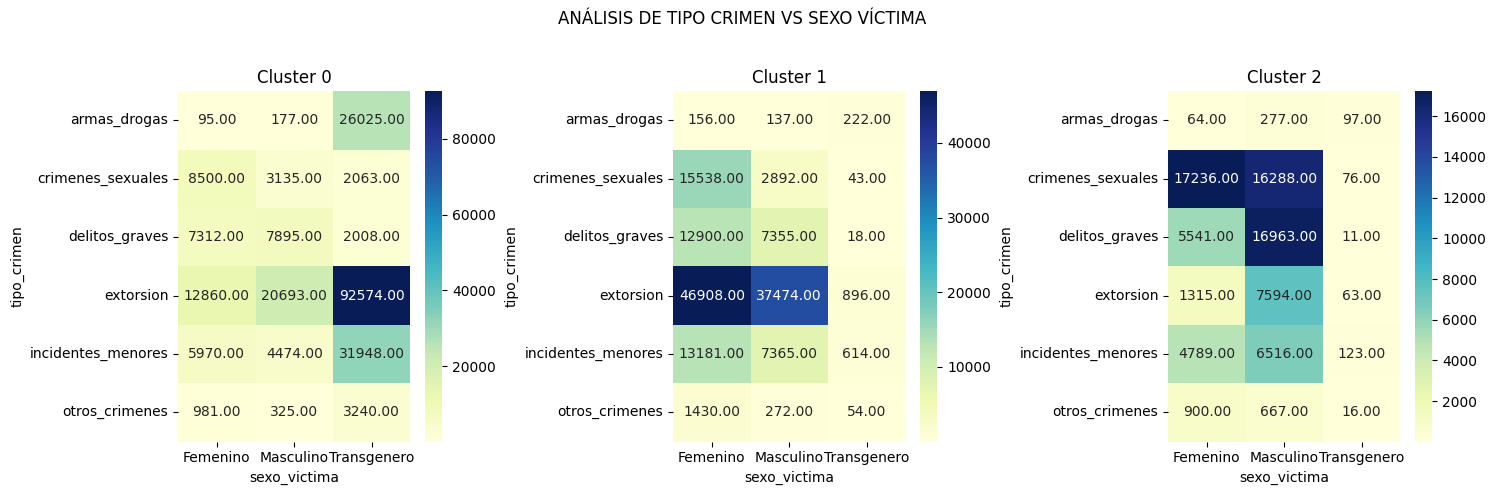

In [37]:
manhattan_cluster_kmodes0 = categoricas_manhattan[categoricas_manhattan['labels']==0]
manhattan_cluster_kmodes1 = categoricas_manhattan[categoricas_manhattan['labels']==1]
manhattan_cluster_kmodes2 = categoricas_manhattan[categoricas_manhattan['labels']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster_kmodes0['tipo_crimen'], manhattan_cluster_kmodes0['sexo_victima'])
ct1 = pd.crosstab(manhattan_cluster_kmodes1['tipo_crimen'], manhattan_cluster_kmodes1['sexo_victima'])
ct2 = pd.crosstab(manhattan_cluster_kmodes2['tipo_crimen'], manhattan_cluster_kmodes2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

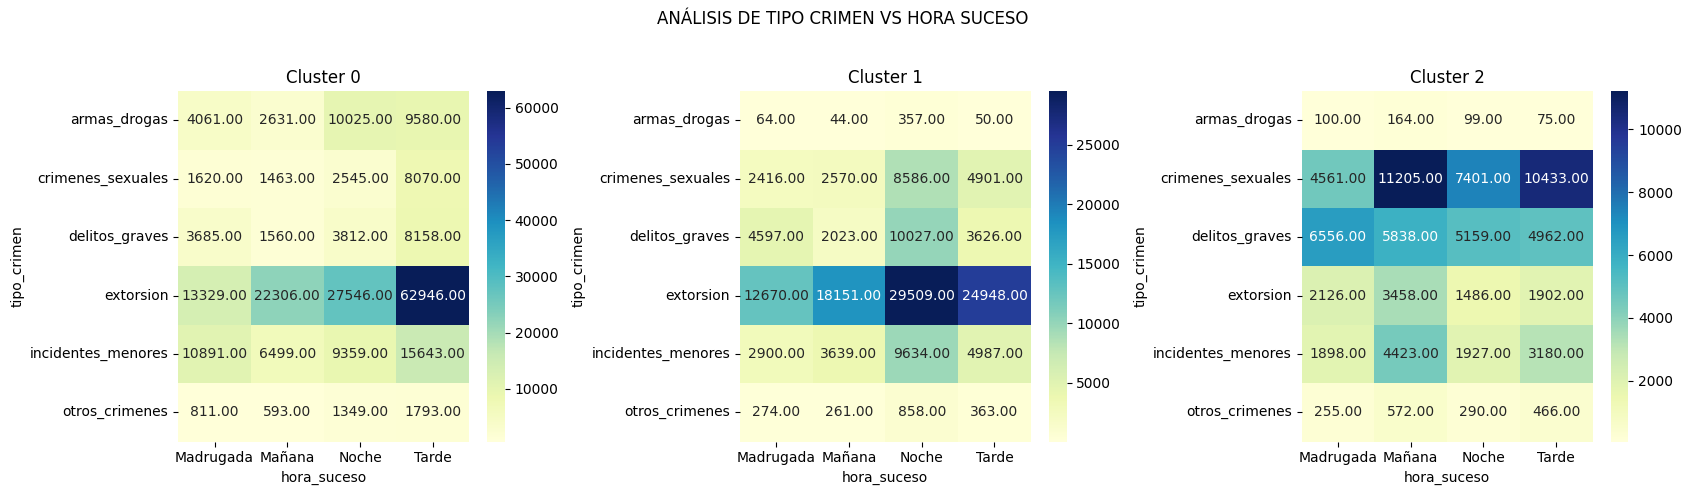

In [38]:
fig, ax = plt.subplots(1,3, figsize = (17,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(manhattan_cluster_kmodes0['tipo_crimen'], manhattan_cluster_kmodes0['hora_suceso'])
ct1 = pd.crosstab(manhattan_cluster_kmodes1['tipo_crimen'], manhattan_cluster_kmodes1['hora_suceso'])
ct2 = pd.crosstab(manhattan_cluster_kmodes2['tipo_crimen'], manhattan_cluster_kmodes2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

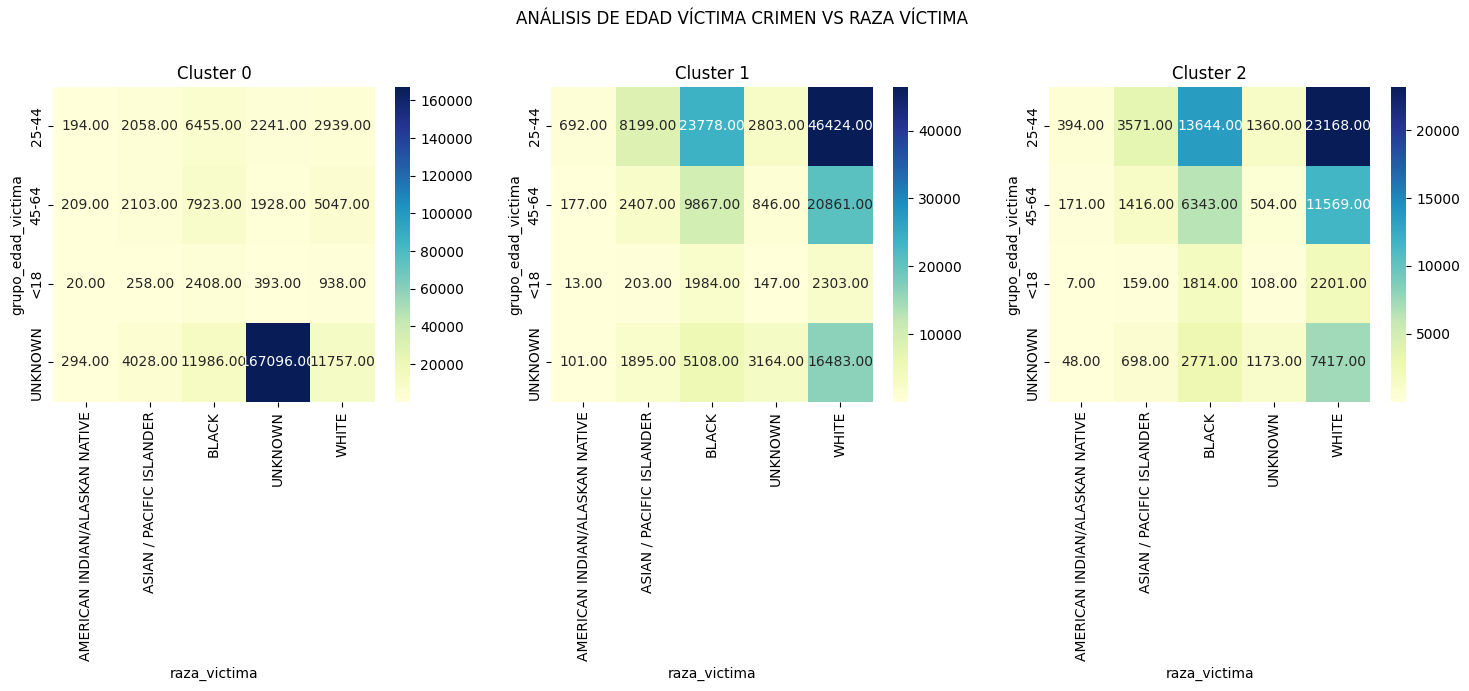

In [39]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster_kmodes0['grupo_edad_victima'], manhattan_cluster_kmodes0['raza_victima'])
ct1 = pd.crosstab(manhattan_cluster_kmodes1['grupo_edad_victima'], manhattan_cluster_kmodes1['raza_victima'])
ct2 = pd.crosstab(manhattan_cluster_kmodes2['grupo_edad_victima'], manhattan_cluster_kmodes2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

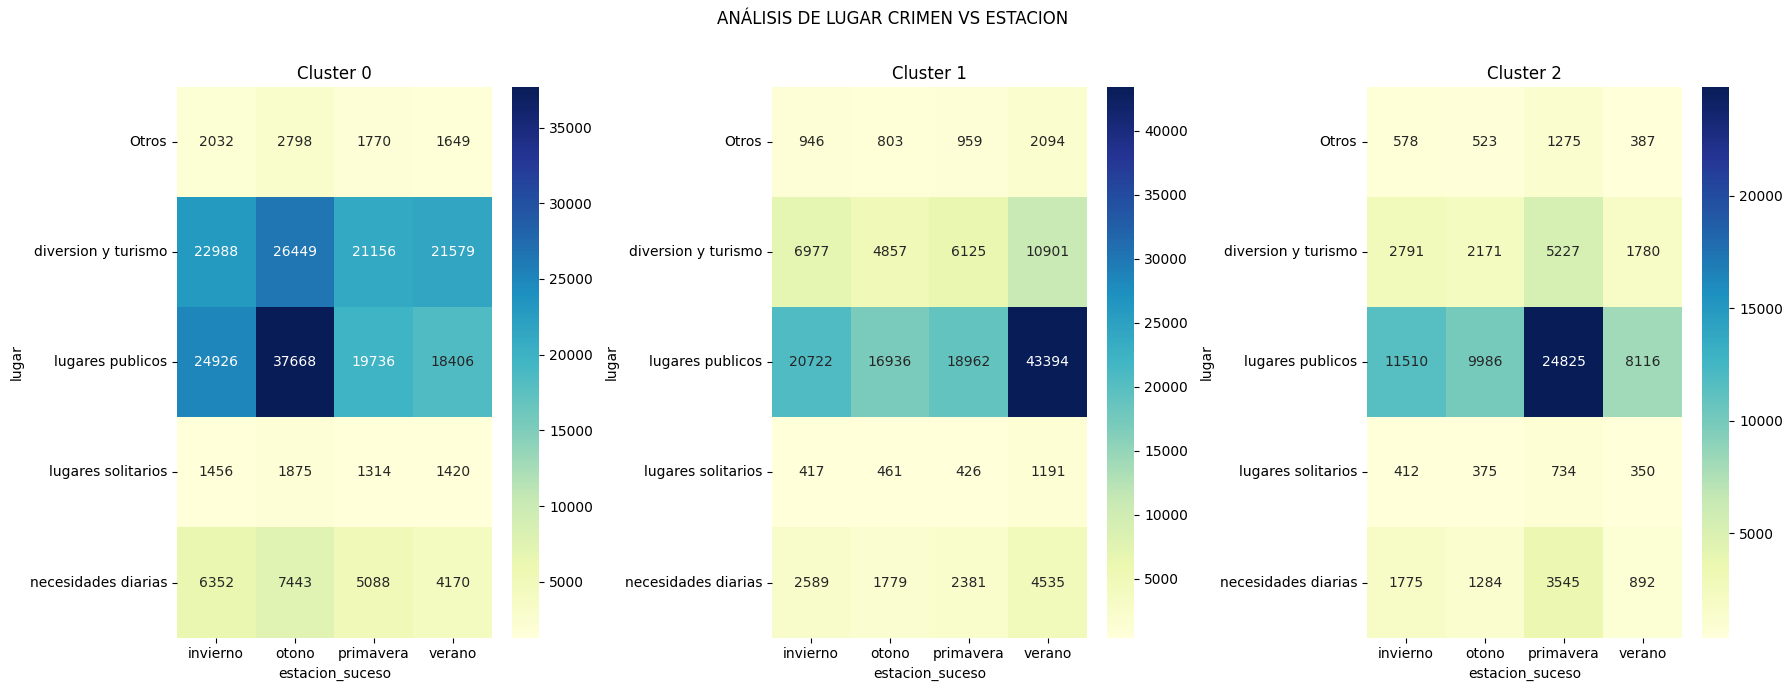

In [40]:
fig, ax = plt.subplots(1,3, figsize = (18,7))
fig.suptitle('ANÁLISIS DE LUGAR CRIMEN VS ESTACION \n')
ct0 = pd.crosstab(manhattan_cluster_kmodes0['lugar'], manhattan_cluster_kmodes0['estacion_suceso'])
ct1 = pd.crosstab(manhattan_cluster_kmodes1['lugar'], manhattan_cluster_kmodes1['estacion_suceso'])
ct2 = pd.crosstab(manhattan_cluster_kmodes2['lugar'], manhattan_cluster_kmodes2['estacion_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [41]:
for column in categoricas_manhattan.columns:
  if column not in ['labels', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    aux1 = categoricas_manhattan.groupby(['labels', column]).size().reset_index().rename(columns = {0:'casos'})
    aux2 = categoricas_manhattan.groupby('labels').size().reset_index().rename(columns = {0:'casos_totales'})
    aux3 = aux1.merge(aux2,how='left', on = 'labels')
    aux3['participacion'] = aux3['casos']/aux3['casos_totales']
    aux3.drop(columns = ['casos_totales'], inplace = True)
    pd.options.display.float_format = '{:.1%}'.format 
    display(aux3)
    print('\n')
  pd.reset_option('display.float_format')

Variable hora_suceso:


,labels,hora_suceso,casos,participacion
0,0,Madrugada,34397,14.9%
1,0,Mañana,35052,15.2%
2,0,Noche,54636,23.7%
3,0,Tarde,106190,46.1%
4,1,Madrugada,22921,15.5%
5,1,Mañana,26688,18.1%
6,1,Noche,58971,40.0%
7,1,Tarde,38875,26.4%
8,2,Madrugada,15496,19.7%
9,2,Mañana,25660,32.7%




Variable grupo_edad_sospechoso:


,labels,grupo_edad_sospechoso,casos,participacion
0,0,25-44,60739,26.4%
1,0,45-64,25771,11.2%
2,0,<18,5909,2.6%
3,0,UNKNOWN,137856,59.9%
4,1,25-44,18630,12.6%
5,1,45-64,6103,4.1%
6,1,<18,2044,1.4%
7,1,UNKNOWN,120678,81.8%
8,2,25-44,30489,38.8%
9,2,45-64,11899,15.2%




Variable raza_sospechoso:


,labels,raza_sospechoso,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,402,0.2%
1,0,ASIAN / PACIFIC ISLANDER,4869,2.1%
2,0,BLACK,88785,38.6%
3,0,UNKNOWN,89282,38.8%
4,0,WHITE,46937,20.4%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,179,0.1%
6,1,ASIAN / PACIFIC ISLANDER,1647,1.1%
7,1,BLACK,27495,18.6%
8,1,UNKNOWN,105895,71.8%
9,1,WHITE,12239,8.3%




Variable sexo_sospechoso:


,labels,sexo_sospechoso,casos,participacion
0,0,Desconocido,80724,35.1%
1,0,Femenino,26984,11.7%
2,0,Masculino,122567,53.2%
3,1,Desconocido,103428,70.1%
4,1,Femenino,16997,11.5%
5,1,Masculino,27030,18.3%
6,2,Desconocido,4926,6.3%
7,2,Femenino,14260,18.2%
8,2,Masculino,59350,75.6%




Variable grupo_edad_victima:


,labels,grupo_edad_victima,casos,participacion
0,0,25-44,13887,6.0%
1,0,45-64,17210,7.5%
2,0,<18,4017,1.7%
3,0,UNKNOWN,195161,84.8%
4,1,25-44,81896,55.5%
5,1,45-64,34158,23.2%
6,1,<18,4650,3.2%
7,1,UNKNOWN,26751,18.1%
8,2,25-44,42137,53.7%
9,2,45-64,20003,25.5%




Variable raza_victima:


,labels,raza_victima,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,717,0.3%
1,0,ASIAN / PACIFIC ISLANDER,8447,3.7%
2,0,BLACK,28772,12.5%
3,0,UNKNOWN,171658,74.5%
4,0,WHITE,20681,9.0%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,983,0.7%
6,1,ASIAN / PACIFIC ISLANDER,12704,8.6%
7,1,BLACK,40737,27.6%
8,1,UNKNOWN,6960,4.7%
9,1,WHITE,86071,58.4%




Variable sexo_victima:


,labels,sexo_victima,casos,participacion
0,0,Femenino,35718,15.5%
1,0,Masculino,36699,15.9%
2,0,Transgenero,157858,68.6%
3,1,Femenino,90113,61.1%
4,1,Masculino,55495,37.6%
5,1,Transgenero,1847,1.3%
6,2,Femenino,29845,38.0%
7,2,Masculino,48305,61.5%
8,2,Transgenero,386,0.5%




Variable tipo_crimen:


,labels,tipo_crimen,casos,participacion
0,0,armas_drogas,26297,11.4%
1,0,crimenes_sexuales,13698,5.9%
2,0,delitos_graves,17215,7.5%
3,0,extorsion,126127,54.8%
4,0,incidentes_menores,42392,18.4%
5,0,otros_crimenes,4546,2.0%
6,1,armas_drogas,515,0.3%
7,1,crimenes_sexuales,18473,12.5%
8,1,delitos_graves,20273,13.7%
9,1,extorsion,85278,57.8%




Variable lugar:


,labels,lugar,casos,participacion
0,0,Otros,8249,3.6%
1,0,diversion y turismo,92172,40.0%
2,0,lugares publicos,100736,43.7%
3,0,lugares solitarios,6065,2.6%
4,0,necesidades diarias,23053,10.0%
5,1,Otros,4802,3.3%
6,1,diversion y turismo,28860,19.6%
7,1,lugares publicos,100014,67.8%
8,1,lugares solitarios,2495,1.7%
9,1,necesidades diarias,11284,7.7%




Variable dia_suceso:


,labels,dia_suceso,casos,participacion
0,0,domingo,25976,11.3%
1,0,jueves,35184,15.3%
2,0,lunes,26998,11.7%
3,0,martes,33750,14.7%
4,0,miercoles,30868,13.4%
5,0,sabado,32076,13.9%
6,0,viernes,45423,19.7%
7,1,domingo,19725,13.4%
8,1,jueves,21453,14.5%
9,1,lunes,17069,11.6%




Variable estacion_suceso:


,labels,estacion_suceso,casos,participacion
0,0,invierno,57754,25.1%
1,0,otono,76233,33.1%
2,0,primavera,49064,21.3%
3,0,verano,47224,20.5%
4,1,invierno,31651,21.5%
5,1,otono,24836,16.8%
6,1,primavera,28853,19.6%
7,1,verano,62115,42.1%
8,2,invierno,17066,21.7%
9,2,otono,14339,18.3%




Variable mes_suceso:


,labels,mes_suceso,casos,participacion
0,0,abril,16658,7.2%
1,0,agosto,16494,7.2%
2,0,diciembre,50341,21.9%
3,0,febrero,18734,8.1%
4,0,julio,13458,5.8%
5,0,junio,16984,7.4%
6,0,marzo,16579,7.2%
7,0,mayo,15422,6.7%
8,0,noviembre,24654,10.7%
9,0,octubre,23679,10.3%
